In [ ]:
!pip install transformers
!pip install datasets
!pip install peft
!pip install evaluate
!pip install torch
!pip install numpy
!pip install pandas
!pip install scikit-learn

In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import pandas as pd


C:\Users\talk2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data To Train On

In [2]:
neologism_data = pd.read_csv('./base_data_full.csv')

In [3]:
neologism_data['sentence'] = neologism_data['sentence'].astype(str)
neologism_data['sentiment'] = neologism_data['sentiment'].astype(str)
def assign_label(sentiment):
    if sentiment == 'positive':
        return 2
    elif sentiment == 'neutral':
        return 1
    else:
        return 0

neologism_data['label'] = neologism_data['sentiment'].apply(assign_label)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    neologism_data['sentence'], neologism_data['label'], test_size=0.2, random_state=42
)

# Create DatasetDict
dataset = DatasetDict({
    'train': Dataset.from_dict({'label': y_train.tolist(), 'sentence': x_train.tolist()}),
    'validation': Dataset.from_dict({'label': y_test.tolist(), 'sentence': x_test.tolist()})
})

In [5]:
neologism_data

,word,sentence,sentiment,label
0,cx,My new phone's cx is unbelievably smooth; scr...,positive,2
1,crispr,Scientists are using crispr technology to edit...,positive,2
2,defi,"Despite the market volatility, my defi invest...",positive,2
3,oled,"Despite the higher price, the oled screen's vi...",positive,2
4,longtermism,"Despite the immediate crisis, the government's...",positive,2
...,...,...,...,...
2739,blackout,The city experienced a complete blackout after...,negative,0
2740,blackout,"After the power outage, the city experienced a...",negative,0
2741,blackout,The unexpected blackout plunged the city into ...,negative,0
2742,mobilization,The company's sudden mobilization of resources...,negative,0


### Data To Test With

In [6]:
reddit_df = pd.read_csv('./all_sampled_twitter.csv')

In [7]:
reddit_df

,text,label
0,"""@mattduss @chrislhayes if ISIS does gain a fo...",0
1,"""Sad news! 150 people shot, drowned in Yobe ri...",0
2,@StephenNolan they all served and died under t...,0
3,Rousey vs. Holm may be the biggest waste of a ...,0
4,@user Amy Schumer is the stereotypical 1st wor...,0
...,...,...
8739,The city experienced a complete blackout after...,0
8740,"After the power outage, the city experienced a...",0
8741,The unexpected blackout plunged the city into ...,0
8742,The company's sudden mobilization of resources...,0


In [8]:
print(reddit_df['text'].dtype)
print(reddit_df['label'].dtype)

object
int64


In [9]:
reddit_df = reddit_df.dropna(subset=['text', 'label'])
reddit_df['text'] = reddit_df['text'].astype(str)
reddit_df['label'] = reddit_df['label'].astype(float)
def assign_label(score):
    if score < -0.5:
        return 0  # Negative
    elif -0.5 <= score <= 0.5:
        return 1  # Neutral
    else:
        return 2  # Positive

# reddit_df['label'] = reddit_df['sentiment'].apply(assign_label)

In [10]:
neo_words = neologism_data.word
neo_words_set = set(neo_words.str.lower())

In [11]:
fil_reddit_df = reddit_df[reddit_df['text'].str.contains('|'.join(neo_words_set), case=False, na=False)]

### Model

In [12]:
model_checkpoint = 'ahmedrachid/FinancialBERT-Sentiment-Analysis'

id2label = {0: "negative", 1: "positive", 2: "neutral"}
label2id = {"negative":0, "positive":1, "neutral": 2}

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)

In [ ]:
model2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=3, id2label=id2label, label2id=label2id)
model2.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
# display architecture
# model
model.to("cuda")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Preprocess Data

In [14]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [15]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["sentence"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [16]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map: 100%|██████████| 549/549 [00:00<00:00, 38920.17 examples/s]


DatasetDict({
    train: Dataset({
        features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2195
    })
    validation: Dataset({
        features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 549
    })
})

In [17]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Evaluation

In [18]:
accuracy_eval = evaluate.load("accuracy")

In [19]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy_eval.compute(predictions=predictions, references=labels)}

In [20]:
text_list = ["Listening to the retro playlist filled with 80's synth-pop hits, he was overwhelmed by a wave of falstalagia.", "That fit is straight fire, no cap, you're looking mad schmick", "Taylor swift’s new album just slaps hard.", "The candidate's speech was pure clickbait, all sizzle and no steak.", "Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more deserving for success than anyone who actually worked for it."]


### Apply untrained model to text

In [55]:
print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt").to("cuda")
    # compute logits
    logits = model2(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
Listening to the retro playlist filled with 80's synth-pop hits, he was overwhelmed by a wave of falstalagia. - positive
That fit is straight fire, no cap, you're looking mad schmick - positive
Taylor swift’s new album just slaps hard. - positive
The candidate's speech was pure clickbait, all sizzle and no steak. - positive
Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more deserving for success than anyone who actually worked for it. - neutral


In [56]:
import torch
import pandas as pd
from tqdm import tqdm

# Create a list to store results
results = []

# Iterate through the DataFrame rows
for index, row in tqdm(reddit_df.iterrows(), total=len(reddit_df)):
    text = row['text']
    # print(text)
    true_label = row['label']  # Assuming the column name for labels is 'label'

    # Tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    # Compute logits
    logits = model2(inputs).logits

    # Convert logits to label
    predictions = torch.argmax(logits)

    # Map the predicted label to human-readable form
    predicted_label = predictions.tolist()

    # Append results to the list
    results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

# Convert the results into a DataFrame
predictions_df = pd.DataFrame(results)

100%|██████████| 8744/8744 [01:15<00:00, 115.60it/s]


In [69]:
neologism_data

,word,sentence,sentiment,label
0,cx,My new phone's cx is unbelievably smooth; scr...,positive,2
1,crispr,Scientists are using crispr technology to edit...,positive,2
2,defi,"Despite the market volatility, my defi invest...",positive,2
3,oled,"Despite the higher price, the oled screen's vi...",positive,2
4,longtermism,"Despite the immediate crisis, the government's...",positive,2
...,...,...,...,...
2739,blackout,The city experienced a complete blackout after...,negative,0
2740,blackout,"After the power outage, the city experienced a...",negative,0
2741,blackout,The unexpected blackout plunged the city into ...,negative,0
2742,mobilization,The company's sudden mobilization of resources...,negative,0


In [70]:
import torch
import pandas as pd
from tqdm import tqdm

# Create a list to store results
results = []

# Iterate through the DataFrame rows
for index, row in tqdm(neologism_data.iterrows(), total=len(neologism_data)):
    text = row['sentence']
    # print(text)
    true_label = row['label']  # Assuming the column name for labels is 'label'

    # Tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    # Compute logits
    logits = model2(inputs).logits

    # Convert logits to label
    predictions = torch.argmax(logits)

    # Map the predicted label to human-readable form
    predicted_label = predictions.tolist()

    # Append results to the list
    results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

# Convert the results into a DataFrame
predictions_df_1 = pd.DataFrame(results)

100%|██████████| 2744/2744 [00:23<00:00, 116.58it/s]


In [57]:
predictions_df

,text,true_label,predicted_label
0,"""@mattduss @chrislhayes if ISIS does gain a fo...",0.0,2
1,"""Sad news! 150 people shot, drowned in Yobe ri...",0.0,1
2,@StephenNolan they all served and died under t...,0.0,1
3,Rousey vs. Holm may be the biggest waste of a ...,0.0,1
4,@user Amy Schumer is the stereotypical 1st wor...,0.0,1
...,...,...,...
8739,The city experienced a complete blackout after...,0.0,0
8740,"After the power outage, the city experienced a...",0.0,0
8741,The unexpected blackout plunged the city into ...,0.0,0
8742,The company's sudden mobilization of resources...,0.0,1


In [58]:
predictions_df['true_label'].value_counts()

true_label
0.0    3490
2.0    3107
1.0    2147
Name: count, dtype: int64

In [59]:
accuracy = (predictions_df['true_label'] == predictions_df['predicted_label']).mean()

# Print results
print("Predictions DataFrame:")
print(predictions_df.head())  # Display first few rows of predictions

print(f"\nAccuracy: {accuracy:.4f}")

Predictions DataFrame:
                                                text  true_label  \
0  "@mattduss @chrislhayes if ISIS does gain a fo...         0.0   
1  "Sad news! 150 people shot, drowned in Yobe ri...         0.0   
2  @StephenNolan they all served and died under t...         0.0   
3  Rousey vs. Holm may be the biggest waste of a ...         0.0   
4  @user Amy Schumer is the stereotypical 1st wor...         0.0   

   predicted_label  
0                2  
1                1  
2                1  
3                1  
4                1  

Accuracy: 0.3981


### Train model

In [21]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['attention.self.query', 'attention.self.key', 'attention.self.value'])

In [22]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'attention.self.value', 'attention.self.key', 'attention.self.query'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [23]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 223,491 || all params: 109,977,606 || trainable%: 0.2032


In [24]:
# hyperparameters
lr = 1e-6
batch_size = 1
num_epochs = 10

In [25]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

C:\Users\talk2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [41]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

C:\Users\talk2\AppData\Local\Temp\ipykernel_44460\769452018.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon ERROR @ 00:15:32] Error: Another instance of codecarbon is probably running as we find `C:\Users\talk2\AppData\Local\Temp\.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 00:15:33] Another instance of codecarbon is already running. Exiting.
  2%|▏         | 502/21950 [00:38<29:29, 12.12it/s]

{'loss': 3.8873, 'grad_norm': 29.406475067138672, 'learning_rate': 9.772209567198178e-07, 'epoch': 0.23}


  5%|▍         | 1002/21950 [01:16<29:38, 11.78it/s]

{'loss': 3.3738, 'grad_norm': 56.5992317199707, 'learning_rate': 9.544419134396355e-07, 'epoch': 0.46}


  7%|▋         | 1502/21950 [01:54<28:14, 12.07it/s]

{'loss': 2.8754, 'grad_norm': 35.75582504272461, 'learning_rate': 9.316628701594532e-07, 'epoch': 0.68}


  9%|▉         | 2002/21950 [02:32<24:58, 13.32it/s]

{'loss': 2.394, 'grad_norm': 55.350738525390625, 'learning_rate': 9.08883826879271e-07, 'epoch': 0.91}


 10%|█         | 2195/21950 [02:56<24:44, 13.30it/s]Trainer is attempting to log a value of "{'accuracy': 0.5646630236794171}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 10%|█         | 2195/21950 [03:00<24:44, 13.30it/s]

{'eval_loss': 2.351900339126587, 'eval_accuracy': {'accuracy': 0.5646630236794171}, 'eval_runtime': 13.7644, 'eval_samples_per_second': 39.885, 'eval_steps_per_second': 39.885, 'epoch': 1.0}


 11%|█▏        | 2502/21950 [03:23<23:03, 14.06it/s]   

{'loss': 2.1956, 'grad_norm': 78.0828857421875, 'learning_rate': 8.861047835990888e-07, 'epoch': 1.14}


 14%|█▎        | 3003/21950 [03:49<11:35, 27.25it/s]

{'loss': 1.932, 'grad_norm': 0.055544234812259674, 'learning_rate': 8.633257403189066e-07, 'epoch': 1.37}


 16%|█▌        | 3502/21950 [04:07<11:45, 26.16it/s]

{'loss': 1.6726, 'grad_norm': 67.0558090209961, 'learning_rate': 8.405466970387244e-07, 'epoch': 1.59}


 18%|█▊        | 4004/21950 [04:25<10:16, 29.12it/s]

{'loss': 1.5083, 'grad_norm': 1.3970465660095215, 'learning_rate': 8.17767653758542e-07, 'epoch': 1.82}


 20%|██        | 4390/21950 [04:38<10:09, 28.82it/s]Trainer is attempting to log a value of "{'accuracy': 0.6375227686703097}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 20%|██        | 4390/21950 [04:44<10:09, 28.82it/s]

{'eval_loss': 1.696574330329895, 'eval_accuracy': {'accuracy': 0.6375227686703097}, 'eval_runtime': 6.3082, 'eval_samples_per_second': 87.029, 'eval_steps_per_second': 87.029, 'epoch': 2.0}


 21%|██        | 4503/21950 [04:48<11:32, 25.18it/s]  

{'loss': 1.5561, 'grad_norm': 0.03776616230607033, 'learning_rate': 7.949886104783598e-07, 'epoch': 2.05}


 23%|██▎       | 5003/21950 [05:06<11:32, 24.48it/s]

{'loss': 1.3977, 'grad_norm': 0.6598190665245056, 'learning_rate': 7.722095671981776e-07, 'epoch': 2.28}


 25%|██▌       | 5505/21950 [05:23<09:20, 29.36it/s]

{'loss': 1.4711, 'grad_norm': 108.30376434326172, 'learning_rate': 7.494305239179954e-07, 'epoch': 2.51}


 27%|██▋       | 6005/21950 [05:40<08:45, 30.36it/s]

{'loss': 1.3746, 'grad_norm': 115.75324249267578, 'learning_rate': 7.266514806378132e-07, 'epoch': 2.73}


 30%|██▉       | 6503/21950 [05:57<08:47, 29.28it/s]

{'loss': 1.2664, 'grad_norm': 77.68270111083984, 'learning_rate': 7.038724373576309e-07, 'epoch': 2.96}


 30%|███       | 6585/21950 [06:00<08:36, 29.76it/s]Trainer is attempting to log a value of "{'accuracy': 0.6794171220400729}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 30%|███       | 6585/21950 [06:06<08:36, 29.76it/s]

{'eval_loss': 1.5216220617294312, 'eval_accuracy': {'accuracy': 0.6794171220400729}, 'eval_runtime': 6.2034, 'eval_samples_per_second': 88.5, 'eval_steps_per_second': 88.5, 'epoch': 3.0}


 32%|███▏      | 7004/21950 [06:21<08:28, 29.37it/s]  

{'loss': 1.4041, 'grad_norm': 130.92437744140625, 'learning_rate': 6.810933940774487e-07, 'epoch': 3.19}


 34%|███▍      | 7504/21950 [06:37<08:25, 28.58it/s]

{'loss': 1.2942, 'grad_norm': 0.4962003827095032, 'learning_rate': 6.583143507972665e-07, 'epoch': 3.42}


 36%|███▋      | 8003/21950 [06:54<07:57, 29.23it/s]

{'loss': 1.4322, 'grad_norm': 26.16788101196289, 'learning_rate': 6.355353075170842e-07, 'epoch': 3.64}


 39%|███▊      | 8502/21950 [07:11<07:47, 28.76it/s]

{'loss': 1.178, 'grad_norm': 0.027422040700912476, 'learning_rate': 6.12756264236902e-07, 'epoch': 3.87}


 40%|███▉      | 8778/21950 [07:20<07:22, 29.78it/s]Trainer is attempting to log a value of "{'accuracy': 0.692167577413479}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 40%|████      | 8781/21950 [07:27<2:24:27,  1.52it/s]

{'eval_loss': 1.4593218564987183, 'eval_accuracy': {'accuracy': 0.692167577413479}, 'eval_runtime': 6.2836, 'eval_samples_per_second': 87.37, 'eval_steps_per_second': 87.37, 'epoch': 4.0}


 41%|████      | 9003/21950 [07:34<07:13, 29.83it/s]  

{'loss': 1.2709, 'grad_norm': 0.33428871631622314, 'learning_rate': 5.899772209567197e-07, 'epoch': 4.1}


 43%|████▎     | 9505/21950 [07:51<06:55, 29.92it/s]

{'loss': 1.3541, 'grad_norm': 76.04105377197266, 'learning_rate': 5.671981776765375e-07, 'epoch': 4.33}


 46%|████▌     | 10004/21950 [08:09<07:24, 26.88it/s]

{'loss': 1.2615, 'grad_norm': 0.030213048681616783, 'learning_rate': 5.444191343963554e-07, 'epoch': 4.56}


 48%|████▊     | 10504/21950 [08:27<06:55, 27.53it/s]

{'loss': 1.243, 'grad_norm': 0.053377822041511536, 'learning_rate': 5.216400911161732e-07, 'epoch': 4.78}


 50%|████▉     | 10973/21950 [08:43<06:22, 28.70it/s]Trainer is attempting to log a value of "{'accuracy': 0.6939890710382514}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 50%|█████     | 10976/21950 [08:50<1:58:00,  1.55it/s]

{'eval_loss': 1.422258973121643, 'eval_accuracy': {'accuracy': 0.6939890710382514}, 'eval_runtime': 6.2619, 'eval_samples_per_second': 87.673, 'eval_steps_per_second': 87.673, 'epoch': 5.0}


 50%|█████     | 11004/21950 [08:51<10:46, 16.93it/s]  

{'loss': 1.3042, 'grad_norm': 0.0780814066529274, 'learning_rate': 4.988610478359909e-07, 'epoch': 5.01}


 52%|█████▏    | 11505/21950 [09:08<06:14, 27.93it/s]

{'loss': 1.1586, 'grad_norm': 0.01193274836987257, 'learning_rate': 4.7608200455580865e-07, 'epoch': 5.24}


 55%|█████▍    | 12005/21950 [09:25<05:33, 29.79it/s]

{'loss': 1.2843, 'grad_norm': 61.220367431640625, 'learning_rate': 4.533029612756264e-07, 'epoch': 5.47}


 57%|█████▋    | 12505/21950 [09:42<05:30, 28.54it/s]

{'loss': 1.3262, 'grad_norm': 110.00357055664062, 'learning_rate': 4.3052391799544417e-07, 'epoch': 5.69}


 59%|█████▉    | 13006/21950 [09:59<04:59, 29.91it/s]

{'loss': 1.2624, 'grad_norm': 62.06783676147461, 'learning_rate': 4.077448747152619e-07, 'epoch': 5.92}


 60%|█████▉    | 13169/21950 [10:04<05:15, 27.84it/s]Trainer is attempting to log a value of "{'accuracy': 0.7030965391621129}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 60%|██████    | 13170/21950 [10:11<05:15, 27.84it/s]

{'eval_loss': 1.4011623859405518, 'eval_accuracy': {'accuracy': 0.7030965391621129}, 'eval_runtime': 6.9304, 'eval_samples_per_second': 79.216, 'eval_steps_per_second': 79.216, 'epoch': 6.0}


 62%|██████▏   | 13505/21950 [10:23<04:53, 28.74it/s]  

{'loss': 1.3967, 'grad_norm': 118.96590423583984, 'learning_rate': 3.849658314350797e-07, 'epoch': 6.15}


 64%|██████▍   | 14002/21950 [10:40<04:34, 28.91it/s]

{'loss': 1.1858, 'grad_norm': 52.993919372558594, 'learning_rate': 3.621867881548975e-07, 'epoch': 6.38}


 66%|██████▌   | 14503/21950 [10:57<04:15, 29.20it/s]

{'loss': 1.1724, 'grad_norm': 0.05728019028902054, 'learning_rate': 3.394077448747152e-07, 'epoch': 6.61}


 68%|██████▊   | 15006/21950 [11:13<03:51, 29.99it/s]

{'loss': 1.1746, 'grad_norm': 0.5041652917861938, 'learning_rate': 3.1662870159453306e-07, 'epoch': 6.83}


 70%|███████   | 15365/21950 [11:26<03:40, 29.85it/s]Trainer is attempting to log a value of "{'accuracy': 0.7067395264116576}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 70%|███████   | 15365/21950 [11:32<03:40, 29.85it/s]

{'eval_loss': 1.3863500356674194, 'eval_accuracy': {'accuracy': 0.7067395264116576}, 'eval_runtime': 6.2528, 'eval_samples_per_second': 87.801, 'eval_steps_per_second': 87.801, 'epoch': 7.0}


 71%|███████   | 15504/21950 [11:37<03:41, 29.16it/s]  

{'loss': 1.3712, 'grad_norm': 0.018336443230509758, 'learning_rate': 2.938496583143508e-07, 'epoch': 7.06}


 73%|███████▎  | 16004/21950 [11:54<03:25, 29.00it/s]

{'loss': 1.4042, 'grad_norm': 0.14042750000953674, 'learning_rate': 2.710706150341686e-07, 'epoch': 7.29}


 75%|███████▌  | 16504/21950 [12:11<03:21, 27.06it/s]

{'loss': 1.1904, 'grad_norm': 0.06434015184640884, 'learning_rate': 2.482915717539863e-07, 'epoch': 7.52}


 77%|███████▋  | 17004/21950 [12:28<02:47, 29.48it/s]

{'loss': 1.1182, 'grad_norm': 88.8946762084961, 'learning_rate': 2.2551252847380408e-07, 'epoch': 7.74}


 80%|███████▉  | 17505/21950 [12:46<02:41, 27.44it/s]

{'loss': 1.1556, 'grad_norm': 6.613450050354004, 'learning_rate': 2.0273348519362184e-07, 'epoch': 7.97}


 80%|████████  | 17560/21950 [12:48<02:31, 28.99it/s]Trainer is attempting to log a value of "{'accuracy': 0.7122040072859745}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 80%|████████  | 17560/21950 [12:54<02:31, 28.99it/s]

{'eval_loss': 1.376961350440979, 'eval_accuracy': {'accuracy': 0.7122040072859745}, 'eval_runtime': 6.3582, 'eval_samples_per_second': 86.346, 'eval_steps_per_second': 86.346, 'epoch': 8.0}


 82%|████████▏ | 18005/21950 [13:10<02:14, 29.30it/s]

{'loss': 1.262, 'grad_norm': 0.026941386982798576, 'learning_rate': 1.7995444191343963e-07, 'epoch': 8.2}


 84%|████████▍ | 18504/21950 [13:27<01:56, 29.53it/s]

{'loss': 1.1589, 'grad_norm': 76.94734954833984, 'learning_rate': 1.571753986332574e-07, 'epoch': 8.43}


 87%|████████▋ | 19006/21950 [13:45<01:38, 29.84it/s]

{'loss': 1.342, 'grad_norm': 200.4207305908203, 'learning_rate': 1.3439635535307517e-07, 'epoch': 8.66}


 89%|████████▉ | 19504/21950 [14:01<01:25, 28.71it/s]

{'loss': 1.322, 'grad_norm': 0.045922644436359406, 'learning_rate': 1.1161731207289294e-07, 'epoch': 8.88}


 90%|████████▉ | 19754/21950 [14:10<01:12, 30.17it/s]Trainer is attempting to log a value of "{'accuracy': 0.7122040072859745}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 90%|█████████ | 19755/21950 [14:16<01:12, 30.17it/s]

{'eval_loss': 1.3709583282470703, 'eval_accuracy': {'accuracy': 0.7122040072859745}, 'eval_runtime': 6.2248, 'eval_samples_per_second': 88.196, 'eval_steps_per_second': 88.196, 'epoch': 9.0}


 91%|█████████ | 20006/21950 [14:25<01:06, 29.40it/s]

{'loss': 1.1908, 'grad_norm': 115.17881774902344, 'learning_rate': 8.88382687927107e-08, 'epoch': 9.11}


 93%|█████████▎| 20505/21950 [14:42<00:49, 29.19it/s]

{'loss': 1.094, 'grad_norm': 48.1948356628418, 'learning_rate': 6.605922551252847e-08, 'epoch': 9.34}


 96%|█████████▌| 21005/21950 [14:59<00:31, 29.68it/s]

{'loss': 1.2354, 'grad_norm': 1.6648550033569336, 'learning_rate': 4.328018223234624e-08, 'epoch': 9.57}


 98%|█████████▊| 21502/21950 [15:16<00:16, 28.00it/s]

{'loss': 1.3562, 'grad_norm': 5.367803573608398, 'learning_rate': 2.0501138952164007e-08, 'epoch': 9.79}


100%|██████████| 21950/21950 [15:31<00:00, 30.27it/s]Trainer is attempting to log a value of "{'accuracy': 0.7122040072859745}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
100%|██████████| 21950/21950 [15:38<00:00, 23.39it/s]

{'eval_loss': 1.3695564270019531, 'eval_accuracy': {'accuracy': 0.7122040072859745}, 'eval_runtime': 6.9042, 'eval_samples_per_second': 79.517, 'eval_steps_per_second': 79.517, 'epoch': 10.0}
{'train_runtime': 938.6101, 'train_samples_per_second': 23.386, 'train_steps_per_second': 23.386, 'train_loss': 1.5019356430853146, 'epoch': 10.0}


TrainOutput(global_step=21950, training_loss=1.5019356430853146, metrics={'train_runtime': 938.6101, 'train_samples_per_second': 23.386, 'train_steps_per_second': 23.386, 'total_flos': 338338934047800.0, 'train_loss': 1.5019356430853146, 'epoch': 10.0})

In [26]:
from transformers import TrainingArguments, TrainerCallback

class LogCallback(TrainerCallback):
    def __init__(self):
        self.logs = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            self.logs.append(logs)

# Initialize the callback
log_callback = LogCallback()

# Add it to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[log_callback]  # Add callback to capture logs
)

# Train the model
trainer.train()

C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\3463072836.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon ERROR @ 00:44:55] Error: Another instance of codecarbon is probably running as we find `C:\Users\talk2\AppData\Local\Temp\.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 00:44:55] Another instance of codecarbon is already running. Exiting.
  2%|▏         | 505/21950 [00:18<13:08, 27.20it/s]

{'loss': 3.9218, 'grad_norm': 28.13003158569336, 'learning_rate': 9.772209567198178e-07, 'epoch': 0.23}


  5%|▍         | 1003/21950 [00:36<12:24, 28.13it/s]

{'loss': 3.4701, 'grad_norm': 43.313499450683594, 'learning_rate': 9.544419134396355e-07, 'epoch': 0.46}


  7%|▋         | 1504/21950 [00:54<12:09, 28.01it/s]

{'loss': 2.9988, 'grad_norm': 33.38022994995117, 'learning_rate': 9.316628701594532e-07, 'epoch': 0.68}


  9%|▉         | 2005/21950 [01:12<12:03, 27.55it/s]

{'loss': 2.5193, 'grad_norm': 45.09774398803711, 'learning_rate': 9.08883826879271e-07, 'epoch': 0.91}


 10%|▉         | 2194/21950 [01:19<11:36, 28.37it/s]Trainer is attempting to log a value of "{'accuracy': 0.5500910746812386}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 10%|█         | 2195/21950 [01:26<11:36, 28.37it/s]

{'eval_loss': 2.4630961418151855, 'eval_accuracy': {'accuracy': 0.5500910746812386}, 'eval_runtime': 6.805, 'eval_samples_per_second': 80.675, 'eval_steps_per_second': 80.675, 'epoch': 1.0}


 11%|█▏        | 2503/21950 [01:37<11:49, 27.41it/s]  

{'loss': 2.3269, 'grad_norm': 60.03541946411133, 'learning_rate': 8.861047835990888e-07, 'epoch': 1.14}


 14%|█▎        | 3004/21950 [01:55<11:22, 27.76it/s]

{'loss': 2.0508, 'grad_norm': 0.06431848555803299, 'learning_rate': 8.633257403189066e-07, 'epoch': 1.37}


 16%|█▌        | 3505/21950 [02:13<12:06, 25.40it/s]

{'loss': 1.7642, 'grad_norm': 65.58116912841797, 'learning_rate': 8.405466970387244e-07, 'epoch': 1.59}


 18%|█▊        | 4006/21950 [02:32<13:56, 21.46it/s]

{'loss': 1.5849, 'grad_norm': 1.8491394519805908, 'learning_rate': 8.17767653758542e-07, 'epoch': 1.82}


 20%|██        | 4390/21950 [02:45<10:17, 28.44it/s]Trainer is attempting to log a value of "{'accuracy': 0.6320582877959927}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 20%|██        | 4390/21950 [02:52<10:17, 28.44it/s]

{'eval_loss': 1.749315857887268, 'eval_accuracy': {'accuracy': 0.6320582877959927}, 'eval_runtime': 6.6019, 'eval_samples_per_second': 83.158, 'eval_steps_per_second': 83.158, 'epoch': 2.0}


 21%|██        | 4504/21950 [02:56<11:01, 26.39it/s]  

{'loss': 1.6338, 'grad_norm': 0.03829888999462128, 'learning_rate': 7.949886104783598e-07, 'epoch': 2.05}


 23%|██▎       | 5005/21950 [03:15<10:15, 27.55it/s]

{'loss': 1.4219, 'grad_norm': 0.7529305219650269, 'learning_rate': 7.722095671981776e-07, 'epoch': 2.28}


 25%|██▌       | 5503/21950 [03:32<10:08, 27.02it/s]

{'loss': 1.5101, 'grad_norm': 109.15316772460938, 'learning_rate': 7.494305239179954e-07, 'epoch': 2.51}


 27%|██▋       | 6004/21950 [03:51<09:37, 27.60it/s]

{'loss': 1.4022, 'grad_norm': 100.69933319091797, 'learning_rate': 7.266514806378132e-07, 'epoch': 2.73}


 30%|██▉       | 6505/21950 [04:09<09:12, 27.96it/s]

{'loss': 1.2965, 'grad_norm': 66.34481048583984, 'learning_rate': 7.038724373576309e-07, 'epoch': 2.96}


 30%|██▉       | 6583/21950 [04:11<09:12, 27.79it/s]Trainer is attempting to log a value of "{'accuracy': 0.668488160291439}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 30%|███       | 6586/21950 [04:18<3:06:44,  1.37it/s]

{'eval_loss': 1.549309492111206, 'eval_accuracy': {'accuracy': 0.668488160291439}, 'eval_runtime': 6.8174, 'eval_samples_per_second': 80.529, 'eval_steps_per_second': 80.529, 'epoch': 3.0}


 32%|███▏      | 7003/21950 [04:34<09:00, 27.68it/s]  

{'loss': 1.4302, 'grad_norm': 129.92617797851562, 'learning_rate': 6.810933940774487e-07, 'epoch': 3.19}


 34%|███▍      | 7502/21950 [04:52<08:09, 29.49it/s]

{'loss': 1.3142, 'grad_norm': 0.6796927452087402, 'learning_rate': 6.583143507972665e-07, 'epoch': 3.42}


 36%|███▋      | 8005/21950 [05:09<07:58, 29.16it/s]

{'loss': 1.4477, 'grad_norm': 26.11180877685547, 'learning_rate': 6.355353075170842e-07, 'epoch': 3.64}


 39%|███▊      | 8504/21950 [05:26<07:40, 29.22it/s]

{'loss': 1.1843, 'grad_norm': 0.025389976799488068, 'learning_rate': 6.12756264236902e-07, 'epoch': 3.87}


 40%|███▉      | 8778/21950 [05:35<07:22, 29.77it/s]Trainer is attempting to log a value of "{'accuracy': 0.6939890710382514}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                    
 40%|████      | 8780/21950 [05:41<07:22, 29.77it/s]

{'eval_loss': 1.4743356704711914, 'eval_accuracy': {'accuracy': 0.6939890710382514}, 'eval_runtime': 6.2564, 'eval_samples_per_second': 87.75, 'eval_steps_per_second': 87.75, 'epoch': 4.0}


 41%|████      | 9003/21950 [05:49<10:20, 20.87it/s]  

{'loss': 1.2834, 'grad_norm': 0.32283174991607666, 'learning_rate': 5.899772209567197e-07, 'epoch': 4.1}


 43%|████▎     | 9502/21950 [06:06<07:42, 26.91it/s]

{'loss': 1.358, 'grad_norm': 78.23210906982422, 'learning_rate': 5.671981776765375e-07, 'epoch': 4.33}


 46%|████▌     | 10003/21950 [06:23<07:00, 28.41it/s]

{'loss': 1.2798, 'grad_norm': 0.029973508790135384, 'learning_rate': 5.444191343963554e-07, 'epoch': 4.56}


 48%|████▊     | 10505/21950 [06:40<06:24, 29.76it/s]

{'loss': 1.2512, 'grad_norm': 0.041368890553712845, 'learning_rate': 5.216400911161732e-07, 'epoch': 4.78}


 50%|████▉     | 10973/21950 [06:56<06:11, 29.58it/s]Trainer is attempting to log a value of "{'accuracy': 0.7067395264116576}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 50%|█████     | 10976/21950 [07:03<1:57:54,  1.55it/s]

{'eval_loss': 1.431223750114441, 'eval_accuracy': {'accuracy': 0.7067395264116576}, 'eval_runtime': 6.2904, 'eval_samples_per_second': 87.275, 'eval_steps_per_second': 87.275, 'epoch': 5.0}


 50%|█████     | 11003/21950 [07:04<12:05, 15.10it/s]  

{'loss': 1.3108, 'grad_norm': 0.07456552237272263, 'learning_rate': 4.988610478359909e-07, 'epoch': 5.01}


 52%|█████▏    | 11505/21950 [07:21<05:55, 29.41it/s]

{'loss': 1.1644, 'grad_norm': 0.01200502272695303, 'learning_rate': 4.7608200455580865e-07, 'epoch': 5.24}


 55%|█████▍    | 12005/21950 [07:37<05:37, 29.48it/s]

{'loss': 1.2927, 'grad_norm': 58.65903091430664, 'learning_rate': 4.533029612756264e-07, 'epoch': 5.47}


 57%|█████▋    | 12504/21950 [07:54<05:18, 29.68it/s]

{'loss': 1.3263, 'grad_norm': 119.75128173828125, 'learning_rate': 4.3052391799544417e-07, 'epoch': 5.69}


 59%|█████▉    | 13004/21950 [08:11<05:12, 28.66it/s]

{'loss': 1.2737, 'grad_norm': 60.69326400756836, 'learning_rate': 4.077448747152619e-07, 'epoch': 5.92}


 60%|█████▉    | 13168/21950 [08:17<04:50, 30.23it/s]Trainer is attempting to log a value of "{'accuracy': 0.7067395264116576}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 60%|██████    | 13172/21950 [08:23<1:15:48,  1.93it/s]

{'eval_loss': 1.4080764055252075, 'eval_accuracy': {'accuracy': 0.7067395264116576}, 'eval_runtime': 6.3158, 'eval_samples_per_second': 86.925, 'eval_steps_per_second': 86.925, 'epoch': 6.0}


 62%|██████▏   | 13505/21950 [08:35<04:52, 28.83it/s]  

{'loss': 1.4174, 'grad_norm': 117.42053985595703, 'learning_rate': 3.849658314350797e-07, 'epoch': 6.15}


 64%|██████▍   | 14005/21950 [08:52<04:29, 29.43it/s]

{'loss': 1.1955, 'grad_norm': 50.98035430908203, 'learning_rate': 3.621867881548975e-07, 'epoch': 6.38}


 66%|██████▌   | 14504/21950 [09:08<04:19, 28.66it/s]

{'loss': 1.1849, 'grad_norm': 0.04714624956250191, 'learning_rate': 3.394077448747152e-07, 'epoch': 6.61}


 68%|██████▊   | 15002/21950 [09:26<04:20, 26.67it/s]

{'loss': 1.1777, 'grad_norm': 0.4476619064807892, 'learning_rate': 3.1662870159453306e-07, 'epoch': 6.83}


 70%|██████▉   | 15363/21950 [09:39<03:43, 29.47it/s]Trainer is attempting to log a value of "{'accuracy': 0.7085610200364298}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 70%|███████   | 15365/21950 [09:45<03:43, 29.47it/s]

{'eval_loss': 1.3924455642700195, 'eval_accuracy': {'accuracy': 0.7085610200364298}, 'eval_runtime': 6.2534, 'eval_samples_per_second': 87.792, 'eval_steps_per_second': 87.792, 'epoch': 7.0}


 71%|███████   | 15504/21950 [09:50<04:20, 24.79it/s]  

{'loss': 1.3741, 'grad_norm': 0.018243961036205292, 'learning_rate': 2.938496583143508e-07, 'epoch': 7.06}


 73%|███████▎  | 16004/21950 [10:07<03:22, 29.35it/s]

{'loss': 1.4188, 'grad_norm': 0.1424161195755005, 'learning_rate': 2.710706150341686e-07, 'epoch': 7.29}


 75%|███████▌  | 16502/21950 [10:24<03:06, 29.24it/s]

{'loss': 1.2061, 'grad_norm': 0.04506811499595642, 'learning_rate': 2.482915717539863e-07, 'epoch': 7.52}


 77%|███████▋  | 17005/21950 [10:41<02:46, 29.72it/s]

{'loss': 1.1269, 'grad_norm': 83.81092071533203, 'learning_rate': 2.2551252847380408e-07, 'epoch': 7.74}


 80%|███████▉  | 17503/21950 [10:58<02:34, 28.79it/s]

{'loss': 1.1636, 'grad_norm': 6.440046787261963, 'learning_rate': 2.0273348519362184e-07, 'epoch': 7.97}


 80%|████████  | 17560/21950 [11:00<02:25, 30.27it/s]Trainer is attempting to log a value of "{'accuracy': 0.7085610200364298}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 80%|████████  | 17560/21950 [11:06<02:25, 30.27it/s]

{'eval_loss': 1.3825604915618896, 'eval_accuracy': {'accuracy': 0.7085610200364298}, 'eval_runtime': 6.2459, 'eval_samples_per_second': 87.897, 'eval_steps_per_second': 87.897, 'epoch': 8.0}


 82%|████████▏ | 18003/21950 [11:21<02:12, 29.86it/s]

{'loss': 1.2719, 'grad_norm': 0.02715713158249855, 'learning_rate': 1.7995444191343963e-07, 'epoch': 8.2}


 84%|████████▍ | 18503/21950 [11:38<01:57, 29.34it/s]

{'loss': 1.1712, 'grad_norm': 59.86011505126953, 'learning_rate': 1.571753986332574e-07, 'epoch': 8.43}


 87%|████████▋ | 19003/21950 [11:55<01:46, 27.66it/s]

{'loss': 1.3531, 'grad_norm': 184.8612823486328, 'learning_rate': 1.3439635535307517e-07, 'epoch': 8.66}


 89%|████████▉ | 19503/21950 [12:12<01:23, 29.22it/s]

{'loss': 1.3316, 'grad_norm': 0.04489123448729515, 'learning_rate': 1.1161731207289294e-07, 'epoch': 8.88}


 90%|████████▉ | 19752/21950 [12:21<01:13, 30.08it/s]Trainer is attempting to log a value of "{'accuracy': 0.7122040072859745}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
 90%|█████████ | 19756/21950 [12:27<19:12,  1.90it/s]

{'eval_loss': 1.376237392425537, 'eval_accuracy': {'accuracy': 0.7122040072859745}, 'eval_runtime': 6.2469, 'eval_samples_per_second': 87.884, 'eval_steps_per_second': 87.884, 'epoch': 9.0}


 91%|█████████ | 20005/21950 [12:36<01:07, 28.87it/s]

{'loss': 1.1965, 'grad_norm': 108.7828140258789, 'learning_rate': 8.88382687927107e-08, 'epoch': 9.11}


 93%|█████████▎| 20502/21950 [12:52<00:48, 29.78it/s]

{'loss': 1.1043, 'grad_norm': 54.98317337036133, 'learning_rate': 6.605922551252847e-08, 'epoch': 9.34}


 96%|█████████▌| 21002/21950 [13:09<00:32, 29.36it/s]

{'loss': 1.246, 'grad_norm': 1.5826759338378906, 'learning_rate': 4.328018223234624e-08, 'epoch': 9.57}


 98%|█████████▊| 21505/21950 [13:26<00:15, 28.66it/s]

{'loss': 1.3673, 'grad_norm': 6.285111904144287, 'learning_rate': 2.0501138952164007e-08, 'epoch': 9.79}


100%|█████████▉| 21947/21950 [13:41<00:00, 30.22it/s]Trainer is attempting to log a value of "{'accuracy': 0.7122040072859745}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
                                                     
100%|██████████| 21950/21950 [13:47<00:00, 26.52it/s]

{'eval_loss': 1.3746980428695679, 'eval_accuracy': {'accuracy': 0.7122040072859745}, 'eval_runtime': 6.1422, 'eval_samples_per_second': 89.381, 'eval_steps_per_second': 89.381, 'epoch': 10.0}
{'train_runtime': 827.7617, 'train_samples_per_second': 26.517, 'train_steps_per_second': 26.517, 'train_loss': 1.5321793527103502, 'epoch': 10.0}


TrainOutput(global_step=21950, training_loss=1.5321793527103502, metrics={'train_runtime': 827.7617, 'train_samples_per_second': 26.517, 'train_steps_per_second': 26.517, 'total_flos': 338338934047800.0, 'train_loss': 1.5321793527103502, 'epoch': 10.0})

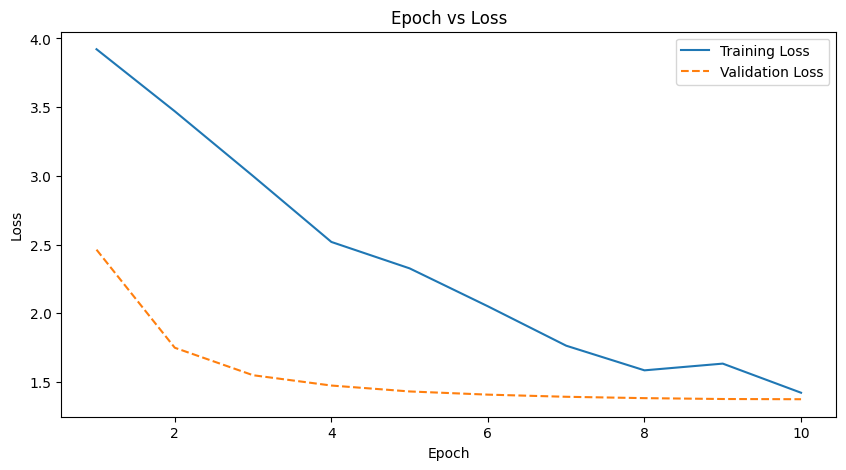

In [30]:
import matplotlib.pyplot as plt

# Extract logs for visualization
logs = log_callback.logs
train_loss = [log.get("loss") for log in logs if "loss" in log]
eval_loss = [log.get("eval_loss") for log in logs if "eval_loss" in log]
epochs = list(range(1, len(train_loss) + 1))

# Visualize Training Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(eval_loss)], train_loss[:len(eval_loss)], label="Training Loss")
if eval_loss:
    plt.plot(epochs[:len(eval_loss)], eval_loss, label="Validation Loss", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

[0.5500910746812386, 0.6320582877959927, 0.668488160291439, 0.6939890710382514, 0.7067395264116576, 0.7067395264116576, 0.7085610200364298, 0.7085610200364298, 0.7122040072859745, 0.7122040072859745]


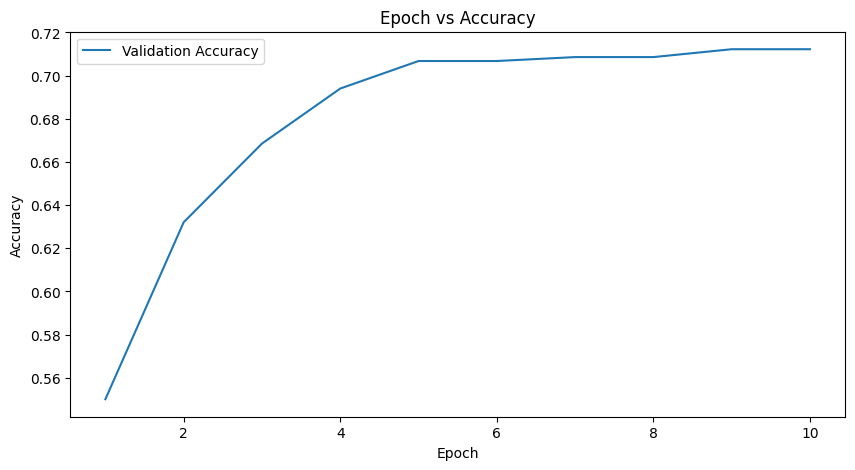

In [32]:
# Example: Visualizing accuracy (if logged in compute_metrics)
accuracy = [log.get("eval_accuracy")["accuracy"] for log in logs if "eval_accuracy" in log]

print(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy) + 1), accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Accuracy")
plt.legend()
plt.show()

In [38]:

from transformers import Trainer, TrainingArguments

# Freeze the layers (e.g., freeze all layers except the last one)
for name, param in model.named_parameters():
    if "classifier" not in name:  # Assume classifier layers are those related to the output
        param.requires_grad = False
    else:
        param.requires_grad = True  # Fine-tune only the classifier layer

# Configuration for LoRA (as in your original code)
# peft_config = LoraConfig(
#     task_type="SEQ_CLS",
#     r=4,
#     lora_alpha=32,
#     lora_dropout=0.01,
#     target_modules=['q_lin']
# )
target_modules = ['q_lin']
peft_config = LoraConfig(task_type="SEQ_CLS", r=8, lora_alpha=16, lora_dropout=0.1, target_modules=target_modules)

# Apply LoRA configuration
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Hyperparameters
lr = 1e-4
batch_size = 4
num_epochs = 10

# Define training arguments
training_args = TrainingArguments(
    output_dir=model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Create trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,  # This will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()

trainable params: 814,083 || all params: 66,597,894 || trainable%: 1.2224


/Users/Priya/miniconda3/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/ql/yrwy8r6j6v734vdm0qsn_r3c0000gn/T/ipykernel_13451/2979904661.py:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.408100,0.549542,{'accuracy': 0.848816029143898}
2,0.346900,0.515034,{'accuracy': 0.8579234972677595}
3,0.357200,0.534522,{'accuracy': 0.8652094717668488}
4,0.290100,0.617303,{'accuracy': 0.8597449908925319}
5,0.293000,0.568953,{'accuracy': 0.8633879781420765}
6,0.247400,0.593689,{'accuracy': 0.8706739526411658}
7,0.245200,0.653592,{'accuracy': 0.8724954462659381}


Trainer is attempting to log a value of "{'accuracy': 0.848816029143898}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8579234972677595}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8652094717668488}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8597449908925319}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8633879781420765}" of

OSError: [Errno 28] No space left on device: '/Users/Priya/.cache/huggingface/metrics/accuracy/default/default_experiment-1-0.arrow'

### Generate prediction

In [34]:
model.to('cuda')

print("Trained model predictions:")
print("--------------------------")
for text in text_list:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cuda") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices

    print(text + " - " + id2label[predictions.tolist()[0]])

Trained model predictions:
--------------------------
Listening to the retro playlist filled with 80's synth-pop hits, he was overwhelmed by a wave of falstalagia. - negative
That fit is straight fire, no cap, you're looking mad schmick - negative
Taylor swift’s new album just slaps hard. - negative
The candidate's speech was pure clickbait, all sizzle and no steak. - negative
Absolutely love how our talent pool is just bursting with sparkle-genius nepo babies, each one more deserving for success than anyone who actually worked for it. - neutral


In [36]:
import torch
import pandas as pd
from tqdm import tqdm

# Assuming reddit_df has 'body' for text and 'label' for the true labels
results = []

# Move the model to MPS (if using a Mac)
model.to('cuda')

# Iterate over the dataframe rows
for index, row in tqdm(reddit_df.iterrows(), total=len(reddit_df)):
    text = row['text']
    true_label = row['label']  # Assuming column 'label' contains the true labels

    # Tokenize the text with padding and truncation
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    # Compute logits using the model
    logits = model(inputs).logits

    # Get the predicted label by finding the index of the max logits
    predictions = torch.max(logits, 1).indices

    # Map prediction to the corresponding label
    predicted_label = id2label[predictions.tolist()[0]]

    # Append the results to the list
    results.append({
        'text': text,
        'true_label': true_label,
        'predicted_label': predicted_label
    })

# Convert the results into a DataFrame
predictions_df_new = pd.DataFrame(results)


100%|██████████| 8744/8744 [01:57<00:00, 74.67it/s]


In [71]:
import torch
import pandas as pd
from tqdm import tqdm

# Create a list to store results
results = []

# Iterate through the DataFrame rows
for index, row in tqdm(neologism_data.iterrows(), total=len(neologism_data)):
    text = row['sentence']
    # print(text)
    true_label = row['label']  # Assuming the column name for labels is 'label'

    # Tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")

    # Compute logits
    logits = model(inputs).logits

    # Convert logits to label
    predictions = torch.argmax(logits)

    # Map the predicted label to human-readable form
    predicted_label = predictions.tolist()

    # Append results to the list
    results.append({'text': text, 'true_label': true_label, 'predicted_label': predicted_label})

# Convert the results into a DataFrame
predictions_df_new_1 = pd.DataFrame(results)

100%|██████████| 2744/2744 [01:10<00:00, 38.98it/s]


In [37]:
predictions_df_new['predicted_label'] = predictions_df_new['predicted_label'].map(label2id)

In [38]:
accuracy = (predictions_df_new['true_label'] == predictions_df_new['predicted_label']).mean()

# Print the DataFrame and accuracy
print("Predictions DataFrame:")
print(predictions_df_new.head())  # Display the first few rows of predictions

print(f"\nAccuracy: {accuracy:.4f}")

Predictions DataFrame:
                                                text  true_label  \
0  "@mattduss @chrislhayes if ISIS does gain a fo...         0.0   
1  "Sad news! 150 people shot, drowned in Yobe ri...         0.0   
2  @StephenNolan they all served and died under t...         0.0   
3  Rousey vs. Holm may be the biggest waste of a ...         0.0   
4  @user Amy Schumer is the stereotypical 1st wor...         0.0   

   predicted_label  
0                0  
1                0  
2                0  
3                0  
4                1  

Accuracy: 0.5594


In [39]:
predictions_df_new["predicted_label"].value_counts()

predicted_label
0    4332
2    2798
1    1614
Name: count, dtype: int64

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

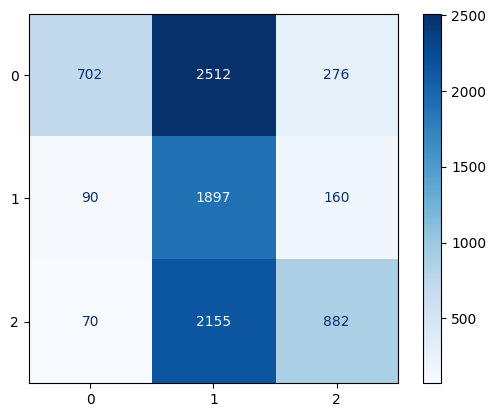

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(predictions_df["true_label"], predictions_df["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

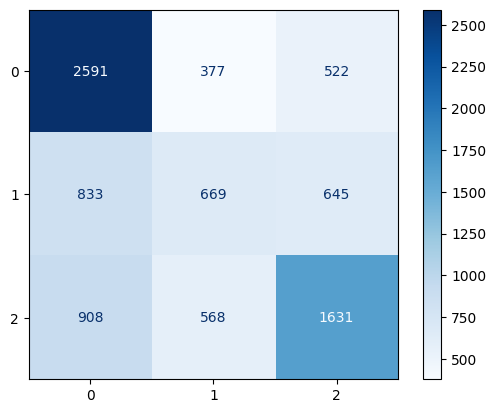

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(predictions_df_new["true_label"], predictions_df_new["predicted_label"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [60]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(predictions_df["true_label"], predictions_df["predicted_label"], target_names=["negative", "neutral", "positive"])
print(report)


              precision    recall  f1-score   support

    negative       0.81      0.20      0.32      3490
     neutral       0.29      0.88      0.44      2147
    positive       0.67      0.28      0.40      3107

    accuracy                           0.40      8744
   macro avg       0.59      0.46      0.39      8744
weighted avg       0.63      0.40      0.38      8744



In [43]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(predictions_df_new["true_label"], predictions_df_new["predicted_label"], target_names=["negative", "neutral", "positive"])
print(report)


              precision    recall  f1-score   support

    negative       0.60      0.74      0.66      3490
     neutral       0.41      0.31      0.36      2147
    positive       0.58      0.52      0.55      3107

    accuracy                           0.56      8744
   macro avg       0.53      0.53      0.52      8744
weighted avg       0.55      0.56      0.55      8744



In [44]:
df = predictions_df_new

C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\1103688226.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = predictions_df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())
C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\1103688226.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_length = predictions_df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())


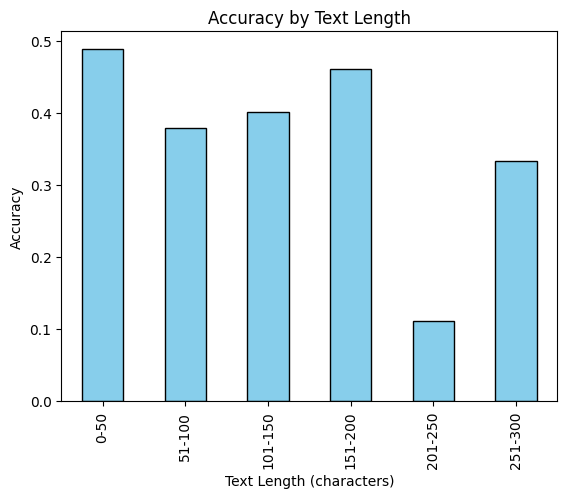

In [62]:
predictions_df["text_length"] = predictions_df["text"].apply(len)

# Group by text length bins
predictions_df["length_bin"] = pd.cut(predictions_df["text_length"], bins=[0, 50, 100, 150, 200, 250, 300], labels=["0-50", "51-100", "101-150", "151-200", "201-250", "251-300"])
accuracy_by_length = predictions_df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())

# Plot accuracy by text length
accuracy_by_length.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Accuracy by Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Accuracy")
plt.show()


C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\1684160093.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy_by_length = df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())
C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\1684160093.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  accuracy_by_length = df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())


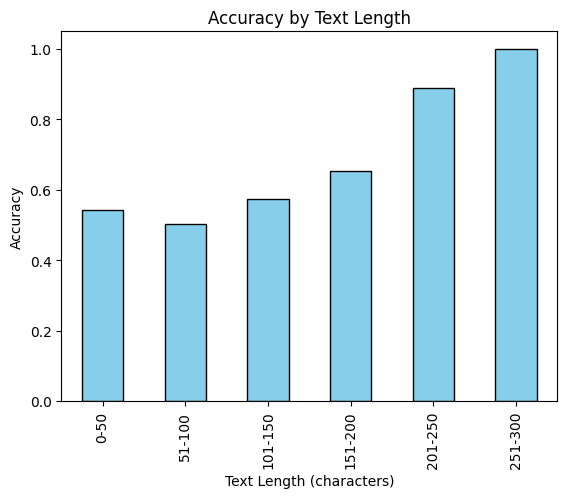

In [45]:
df["text_length"] = df["text"].apply(len)

# Group by text length bins
df["length_bin"] = pd.cut(df["text_length"], bins=[0, 50, 100, 150, 200, 250, 300], labels=["0-50", "51-100", "101-150", "151-200", "201-250", "251-300"])
accuracy_by_length = df.groupby("length_bin").apply(lambda x: (x["true_label"] == x["predicted_label"]).mean())

# Plot accuracy by text length
accuracy_by_length.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Accuracy by Text Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Accuracy")
plt.show()


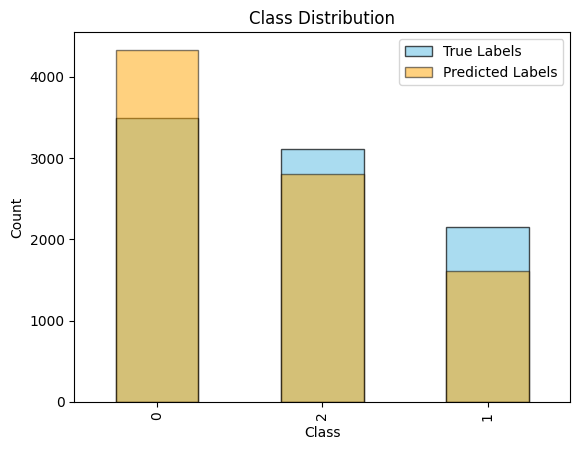

In [47]:
# Distribution of true labels
df["true_label"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black", alpha=0.7, label="True Labels")

# Distribution of predicted labels
df["predicted_label"].value_counts().plot(kind="bar", color="orange", edgecolor="black", alpha=0.5, label="Predicted Labels")

plt.legend()
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

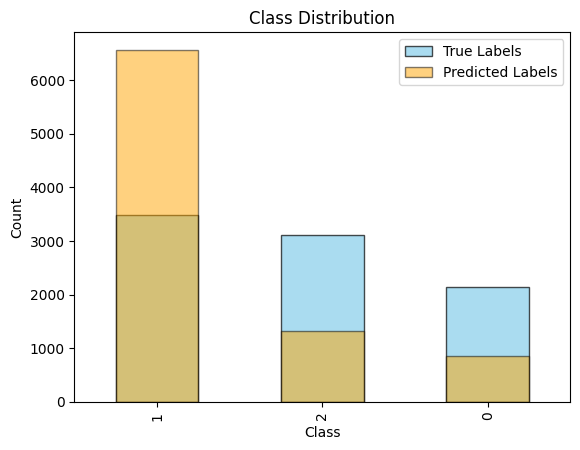

In [65]:
# Distribution of true labels
predictions_df["true_label"].value_counts().plot(kind="bar", color="skyblue", edgecolor="black", alpha=0.7, label="True Labels")

# Distribution of predicted labels
predictions_df["predicted_label"].value_counts().plot(kind="bar", color="orange", edgecolor="black", alpha=0.5, label="Predicted Labels")

plt.legend()
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\2635142298.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_analysis = df.groupby("length_bin").apply(lambda x: (x["true_label"] != x["predicted_label"]).mean())
C:\Users\talk2\AppData\Local\Temp\ipykernel_51044\2635142298.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  length_analysis = df.groupby("length_bin").apply(lambda x: (x["true_label"] != x["predicted_label"]).mean())


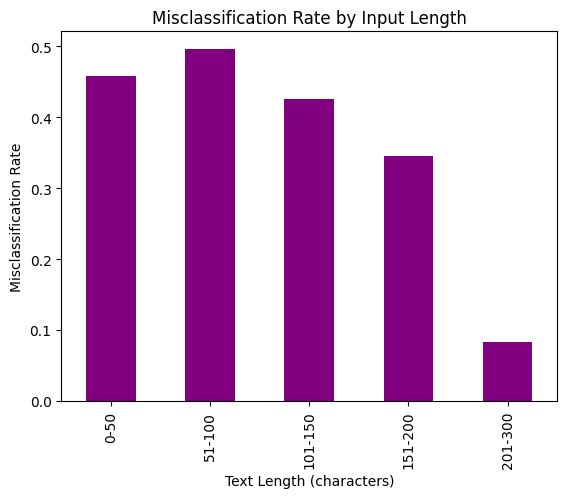

In [50]:
# Group by text length bins
df["length_bin"] = pd.cut(df["text"].apply(len), bins=[0, 50, 100, 150, 200, 300], labels=["0-50", "51-100", "101-150", "151-200", "201-300"])

# Misclassification rate by length
length_analysis = df.groupby("length_bin").apply(lambda x: (x["true_label"] != x["predicted_label"]).mean())
length_analysis.plot(kind="bar", color="purple")
plt.title("Misclassification Rate by Input Length")
plt.xlabel("Text Length (characters)")
plt.ylabel("Misclassification Rate")
plt.show()


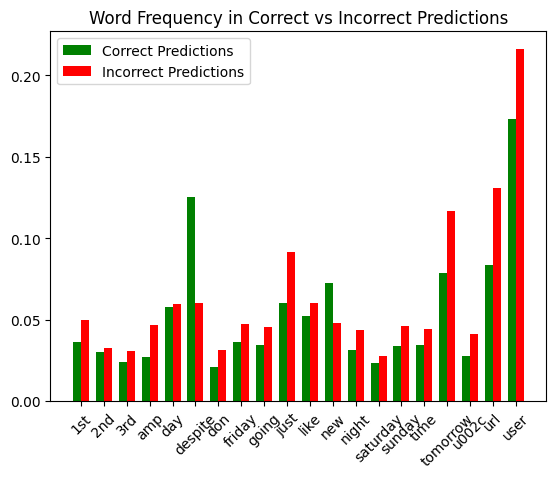

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Vectorize text
vectorizer = CountVectorizer(max_features=20, stop_words="english")
X = vectorizer.fit_transform(df["text"])
words = vectorizer.get_feature_names_out()

# Average counts for correctly and incorrectly predicted samples
correct_mask = df["true_label"] == df["predicted_label"]
correct_avg = np.asarray(X[correct_mask].mean(axis=0)).flatten()
incorrect_avg = np.asarray(X[~correct_mask].mean(axis=0)).flatten()

# Plot
bar_width = 0.35
x = np.arange(len(words))
plt.bar(x, correct_avg, width=bar_width, label="Correct Predictions", color="green")
plt.bar(x + bar_width, incorrect_avg, width=bar_width, label="Incorrect Predictions", color="red")
plt.xticks(x + bar_width / 2, words, rotation=45)
plt.legend()
plt.title("Word Frequency in Correct vs Incorrect Predictions")
plt.show()


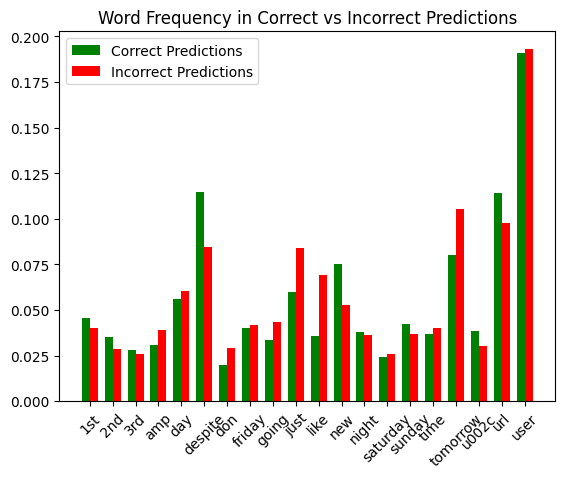

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Vectorize text
vectorizer = CountVectorizer(max_features=20, stop_words="english")
X = vectorizer.fit_transform(df["text"])
words = vectorizer.get_feature_names_out()

# Average counts for correctly and incorrectly predicted samples
correct_mask = predictions_df["true_label"] == predictions_df["predicted_label"]
correct_avg = np.asarray(X[correct_mask].mean(axis=0)).flatten()
incorrect_avg = np.asarray(X[~correct_mask].mean(axis=0)).flatten()

# Plot
bar_width = 0.35
x = np.arange(len(words))
plt.bar(x, correct_avg, width=bar_width, label="Correct Predictions", color="green")
plt.bar(x + bar_width, incorrect_avg, width=bar_width, label="Incorrect Predictions", color="red")
plt.xticks(x + bar_width / 2, words, rotation=45)
plt.legend()
plt.title("Word Frequency in Correct vs Incorrect Predictions")
plt.show()


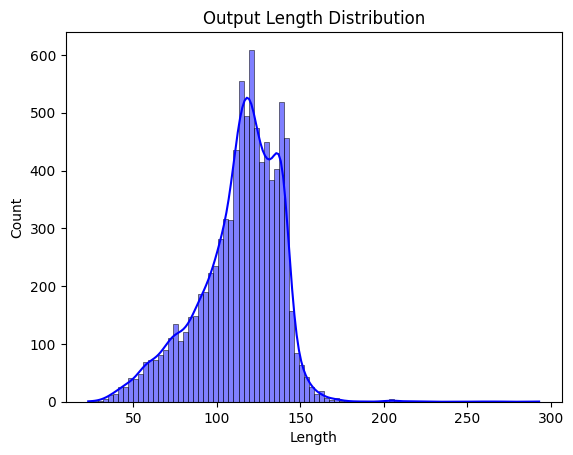

In [52]:
# Add output length comparison
df["output_length"] = df["text"].apply(len)  # Adjust based on output column
sns.histplot(df["output_length"], kde=True, color="blue")
plt.title("Output Length Distribution")
plt.xlabel("Length")
plt.show()


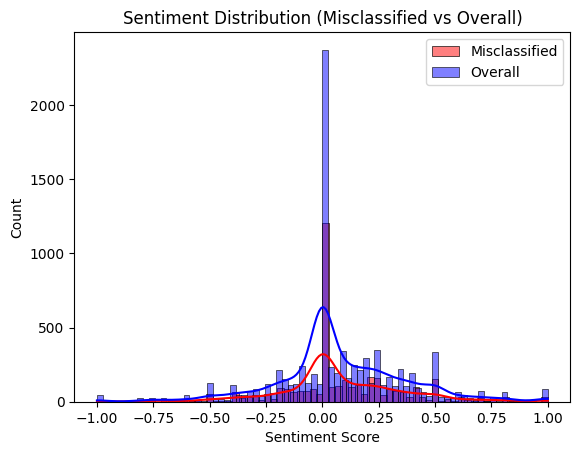

In [53]:
# Add sentiment score (using a sentiment library like VADER or TextBlob)
from textblob import TextBlob

df["sentiment"] = df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution for misclassified samples
misclassified = df[df["true_label"] != df["predicted_label"]]
sns.histplot(misclassified["sentiment"], kde=True, color="red", label="Misclassified")
sns.histplot(df["sentiment"], kde=True, color="blue", label="Overall", alpha=0.5)
plt.legend()
plt.title("Sentiment Distribution (Misclassified vs Overall)")
plt.xlabel("Sentiment Score")
plt.show()


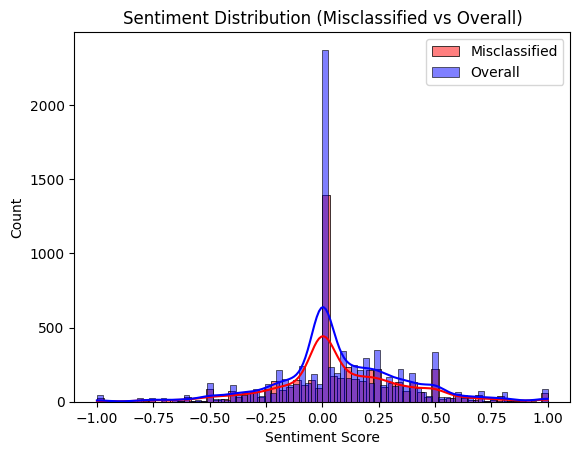

In [64]:
# Add sentiment score (using a sentiment library like VADER or TextBlob)
from textblob import TextBlob

predictions_df["sentiment"] = predictions_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution for misclassified samples
misclassified = predictions_df[predictions_df["true_label"] != predictions_df["predicted_label"]]
sns.histplot(misclassified["sentiment"], kde=True, color="red", label="Misclassified")
sns.histplot(predictions_df["sentiment"], kde=True, color="blue", label="Overall", alpha=0.5)
plt.legend()
plt.title("Sentiment Distribution (Misclassified vs Overall)")
plt.xlabel("Sentiment Score")
plt.show()


In [73]:
import pandas as pd

# Assuming predicted_df and predicted_df_new have 'true_label' and 'predicted_label'
# Let's create a new DataFrame with both original and fine-tuned predictions
df_comparison = pd.DataFrame({
    'text': predictions_df_1['text'],  # or use your text column name
    'true_label': predictions_df_1['true_label'],
    'predicted_label_original': predictions_df_1['predicted_label'],
    'predicted_label_finetuned': predictions_df_new_1['predicted_label']
})

# Case 1: Both models are correct
both_correct = df_comparison[(df_comparison['predicted_label_original'] == df_comparison['true_label']) & 
                             (df_comparison['predicted_label_finetuned'] == df_comparison['true_label'])]

# Case 2: Original correct, Fine-tuned wrong
original_correct_finetuned_wrong = df_comparison[(df_comparison['predicted_label_original'] == df_comparison['true_label']) & 
                                                 (df_comparison['predicted_label_finetuned'] != df_comparison['true_label'])]

# Case 3: Original wrong, Fine-tuned correct
original_wrong_finetuned_correct = df_comparison[(df_comparison['predicted_label_original'] != df_comparison['true_label']) & 
                                                 (df_comparison['predicted_label_finetuned'] == df_comparison['true_label'])]

# Case 4: Both models are incorrect
both_incorrect = df_comparison[(df_comparison['predicted_label_original'] != df_comparison['true_label']) & 
                               (df_comparison['predicted_label_finetuned'] != df_comparison['true_label'])]

# Display the examples for each case
print("Case 1: Both models are correct")
print(both_correct.iloc[0]["text"], "\n")
print(both_correct.iloc[0], "\n")

print("Case 2: Original correct, Fine-tuned wrong")
print(original_correct_finetuned_wrong.iloc[0]["text"], "\n")
print(original_correct_finetuned_wrong.head(), "\n")

print("Case 3: Original wrong, Fine-tuned correct")
print(original_wrong_finetuned_correct.iloc[0]["text"], "\n")
print(original_wrong_finetuned_correct.head(), "\n")

print("Case 4: Both models are incorrect")
print(both_incorrect.iloc[0]["text"], "\n")
print(both_incorrect.head(), "\n")


Case 1: Both models are correct
Despite the market volatility,  my defi investments are surprisingly stable, offering a compelling alternative to traditional finance. 

text                         Despite the market volatility,  my defi invest...
true_label                                                                   2
predicted_label_original                                                     2
predicted_label_finetuned                                                    2
Name: 2, dtype: object 

Case 2: Original correct, Fine-tuned wrong
Despite the hefty price tag, carbon capture technology offers a crucial, albeit imperfect, solution to rising atmospheric CO2 levels. 

                                                  text  true_label  \
12   Despite the hefty price tag, carbon capture te...           1   
44   Seeing angel numbers everywhere lately—I'm eit...           1   
79   Our company's new data culture prioritizes dat...           1   
80   Despite passionate debate,

In [46]:
predictions_df_new.to_csv("financeBert.csv", columns=['text', 'true_label', 'predicted_label'], index=False)


In [ ]:
# 36%

In [ ]:
# 41%

In [ ]:
# 29 -old accuracy